In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm
import cv2
import numpy as np

from utils.model import Model

import os

## Settings

In [2]:
root_dir = 'archive'
batch_size = 30
n_epoch = 20
cuda = True

n_classes = 20

In [3]:
labels_dir = {
    'buffalo': 0,
    'elephant': 1,
    'rhino': 2,
    'zebra': 3,
}
inv_labels_dir = {v: k for k, v in labels_dir.items()}

## Dataset part

In [4]:
class MotyaDataset(Dataset):
    """Motyas dataset."""

    def __init__(self, root_dir, val=False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        classes_dir = [f for f in os.listdir(root_dir)]
        all_files = []
        classes = []
        for class_dir in classes_dir:
            files = [class_dir + '/' + f for f in os.listdir(root_dir + '/' + class_dir) if f.endswith('.jpg')]
            all_files += files
            classes += [class_dir]*len(files)
            
                
        # Validation split
        split = int(len(all_files)*0.8)
        if val == False:
            self.files = all_files[:split]
            self.classes = classes[:split]
        else:
            self.files = all_files[split:]
            self.classes = classes[split:]
            
        

    def __len__(self):
        return len( self.files)
    

    def __getitem__(self, idx):        
        path = self.files[idx][:-4]
        img_class = self.classes[idx]
        
        # Loading image
        image = plt.imread(self.root_dir + '/' + path + '.jpg')
        image = (2.0 * image / 255) - 1.0        
        image = cv2.resize(image, (300, 300))
        image = np.moveaxis(image, 2, 0)
        
        #Loading nuber of animals
        txt_data = open(self.root_dir + '/' + path + '.txt', 'r').readlines()
        animals_n = len(txt_data)

        return image, animals_n #labels_dir[img_class]   #,     #animals_n     #labels_dir[img_class], 

In [5]:
b = MotyaDataset(root_dir)
x = b.__getitem__(0)

In [6]:
train_loader = DataLoader(MotyaDataset(root_dir), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(MotyaDataset(root_dir, val=True), batch_size=batch_size, shuffle=True)

In [7]:
for x in train_loader:
    print(x[1].shape)
    break

torch.Size([30])


In [8]:
x[1]

tensor([3, 2, 2, 1, 2, 1, 1, 1, 2, 1, 3, 3, 2, 1, 1, 2, 1, 2, 1, 5, 1, 1, 3, 2,
        4, 2, 1, 1, 2, 2])

tensor(0.0605, dtype=torch.float64) tensor(0.9978, dtype=torch.float64)


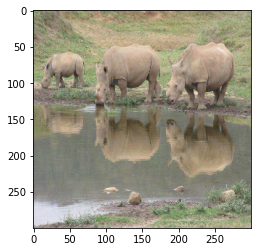

In [9]:
im = x[0][0].permute(1,2,0)
im =  (im + 1)/2

print(im.min(), im.max())
plt.imshow(im)

## Model part

In [10]:
model = Model(n_classes)

Using cache found in /home/admiral/.cache/torch/hub/pytorch_vision_v0.6.0


## Tarin part

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)

In [12]:
if cuda:
    model = model.cuda()
model.train()
    
accuracy = []
overall_loss = []
for epoch in range(n_epoch):  # loop over the dataset multiple times

    model.train()  
    epoch_loss = []
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss = loss.item()
        epoch_loss.append(running_loss)
        
    epoch_loss_mean = np.array(epoch_loss).mean()
    overall_loss.append(epoch_loss_mean)
    print(f'Epoch: {epoch}, Loss: {epoch_loss_mean}')
            
    model.eval()       
    correct = 0
    total = 0
    with torch.no_grad():
        
        for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
            images, labels = data
            
            if cuda:
                images = images.cuda()
            
            outputs = model(images.float()).cpu().detach()
            predicted = outputs.argmax(1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))

print('Finished Training')

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 0, Loss: 3.0214977860450745


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 6 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.9155339896678925


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 11 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 2, Loss: 2.794640821218491


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 14 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 3, Loss: 2.683881175518036


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 15 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 4, Loss: 2.582317352294922


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 16 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5, Loss: 2.469109219312668


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 21 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 6, Loss: 2.3535490214824675


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 22 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 7, Loss: 2.238389754295349


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 25 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 8, Loss: 2.0956604063510893


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 29 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 9, Loss: 1.967838278412819


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 31 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.8552947640419006


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 35 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 11, Loss: 1.7009178519248962


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 36 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 12, Loss: 1.6357216596603394


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 40 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13, Loss: 1.5075079083442688


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 42 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 14, Loss: 1.3994913309812547


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 46 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 15, Loss: 1.3566498771309852


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 45 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 16, Loss: 1.247135581076145


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 48 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 17, Loss: 1.1791974321007728


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 49 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 18, Loss: 1.125540407001972


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy: 51 %


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 19, Loss: 1.0156479224562645


100%|██████████| 11/11 [00:05<00:00,  2.08it/s]

Accuracy: 51 %
Finished Training


In [13]:
'.jpg'.endswith('jpg')

True

In [14]:
torch.save(model.state_dict(), 'weights/counter_model.pth')

## Test part

In [15]:
model = model.eval()

In [16]:
for image, label in val_loader:
    pred = model(image.float().cuda())
    pred = pred.cpu().argmax(1)
    
    print("GT: ", label)
    print("Pred: ", pred)
    break

GT:  tensor([3, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 3, 2, 6, 2, 1, 1, 2, 2, 2, 7, 1, 4, 2,
        2, 1, 1, 2, 2, 4])
Pred:  tensor([ 1,  1,  1,  2,  1,  1,  1,  2,  1,  2,  1,  3,  1,  2,  2,  1,  1, 12,
        13,  1, 17,  2,  2,  2,  3,  1,  1,  1, 10,  2])


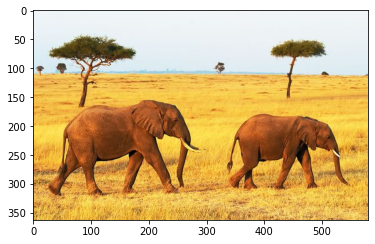

In [17]:
image = plt.imread('archive/elephant/370.jpg')
plt.imshow(image)
image = cv2.resize(image, (300, 300))

image = np.moveaxis(image, 2, 0)

image = (2.0 * image / 255) - 1.0

In [18]:
test = (torch.tensor(image))
test = torch.unsqueeze(test, 0)

In [19]:
test.shape

torch.Size([1, 3, 300, 300])

In [20]:
if cuda:
    test = test.cuda()

print(test.shape)
x = model(test.float())

torch.Size([1, 3, 300, 300])


In [21]:
x

tensor([[-0.3330, -9.1293,  3.5781,  1.9917,  2.0609,  1.7118,  1.1225, -0.0375,
         -0.4943,  0.9978, -0.0476, -0.3606,  0.1763, -0.2850,  0.4636, -0.0095,
         -1.0401, -1.0955,  0.1059, -0.9157]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [22]:
inv_labels_dir[x.argmax().item()]

'rhino'

In [23]:
x.argmax().item()

2